
### Examining racial discrimination in the US job market

#### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

#### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes.

#### Exercise
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Discuss statistical significance.

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
np.random.seed(19)
% matplotlib inline

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for balck-sounding names
sum(data[data.race=='b'].call)

157.0

In [4]:
sum(data[data.race=='w'].call)

235.0

In [5]:
p= pd.DataFrame(data.groupby(['race']).call.sum()).reset_index()
q= pd.DataFrame(data.groupby(['race']).size()).reset_index()
q= q.rename(columns={0: 'total'})
percentages= p.merge(q, how='inner', on= 'race')

In [6]:
percentages['no_call']= percentages['total']-percentages['call']
percentages['fract_call']= percentages['call']/percentages['total']
percentages['fract_nocall']= percentages['no_call']/percentages['total']

In [7]:
percentages

,race,call,total,no_call,fract_call,fract_nocall
0,b,157.0,2435,2278.0,0.064476,0.935524
1,w,235.0,2435,2200.0,0.096509,0.903491


I filter the data of black and white-sounding CVs and compute their mean values. These means correspond to the fraction of people who is called back for interview. 

In [8]:
black= data[data.race=='b']
pb= black.call.mean()
pb

0.0644763857126236

In [9]:
white= data[data.race=='w']
pw= white.call.mean()
pw

0.09650924056768417

In [10]:
diff_proportion_obs= pw-  pb
diff_proportion_obs

0.03203285485506058

According to these results, the white-sounding CVs are called back for interviews 3.2% more. 

## 1. Margin of error and confidence interval of the estimate

In [11]:
class Std_error_and_CI(object):
    
    def distance(self, dist1, dist2):
        diff= dist1.mean() - dist2.mean() 
        return diff
    
    def resampling(self, dist1, dist2):
        '''
        uses bootstraap to create samples
        '''
        sample1= np.random.choice(dist1, size= len(dist1), replace=True)
        sample2= np.random.choice(dist2, size= len(dist2), replace=True)
        return self.distance(sample1, sample2)
    
    def sampling_distr(self, dist1, dist2, niters=1000):
        sampling_dist=np.array([self.resampling(dist1, dist2) for i in range(niters)])
        return sampling_dist 
     
    def get_stats(self, dist1, dist2):
        sampling_d= self.sampling_distr(dist1, dist2)
        plt.hist(sampling_d)
        plt.xlabel('Sampled difference of proportions')
        print ('diff in proportion:', sampling_d.mean())
        print ('standard error:', sampling_d.std())
        print ('95% CI', np.percentile(sampling_d, [2.5, 97.5]) )
        print('margin error:', np.round((np.percentile(sampling_d, 97.5)- sampling_d.mean())*100, 1) , '%' )
        

diff in proportion: 0.0323799
standard error: 0.00776998
95% CI [ 0.01641683  0.04682752]
margin error: 1.4 %


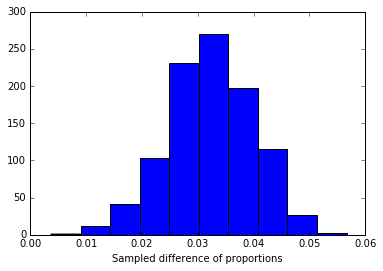

In [12]:
sampling= Std_error_and_CI()
sampling.get_stats(white.call, black.call)

### According to the results shown above, white-sounding CVs are called  $\sim$ 3% more than black-sounding CVs. 

### The margin of error is $1.4\%$ 

## 2. Is the difference in proportions real?

2.1 What test is appropriate for this problem? Does CLT apply? <br>

The appropiate test to apply in this problem is a two sample test to evaluate if there is a significance difference between the two populations. In this problem the CLT applies, because each class (white and black) has more that 30 elements. 

2.2 What are the null and alternate hypotheses?

$H_0$: There is no difference between the two proportions, $p_1-p_2=0$ <br>
$H_1$: There is a difference between the two proportions, $p_1-p_2 \neq 0$. <br>

I will test the hypothesis with a significance level of 1%

In [13]:
class Hypothesis_testing(object):
    
    def distance(self, dist1, dist2):
        diff= dist1.mean() - dist2.mean() 
        return diff
    
    def resample_with_model(self, n, pool):
        '''
        uses permutation to create samples from Ho
        '''
        np.random.shuffle(pool)
        return self.distance(pool[:n], pool[n:])
    
    def test_hypothesis(self, dist1, dist2, niters=1000):
        n, m = len(dist1), len(dist2)
        pool= np.hstack((dist1, dist2))
        sampling_dist= np.array([self.resample_with_model(n, pool) for i in range(niters)] )
        observed_d= self.distance(dist1, dist2)
        if (observed_d >= 0):
            p_value= sum(sampling_dist>= observed_d)/len(sampling_dist)
        if (observed_d <0):
            p_value= sum(sampling_dist<= observed_d)/len(sampling_dist)
        #plt.hist(sampling_dist)
        #plt.plot(observed_d*np.ones(300), np.arange(300), color='gray')
        return p_value

In [14]:
stats= Hypothesis_testing()
p_value= stats.test_hypothesis(white.call, black.call)
p_value

0.0

### The result of above suggest that p_value $<0.001$.  Since p_value is smaller than $1$\%, I reject the null hypothesis. Therefore, The difference in the porportions is a real effect in the population.  